<a href="https://colab.research.google.com/github/KarenLira25/Proyecto1_AnalisisDatos/blob/main/Tarea3_Ajuste_parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

El archivo que se adjunta ”Pueblapos.csv” son datos de los casos registrados(nuevos casos) para Puebla reportados por la secretaría de salud.
1.   Cargar los datos y Graficar
2.   Ajustar la primera ola con mínimos cuadrados.
3.   Ajustar la segunda ola con una cadena de Monte Carlo y dar intervalosde confianza para los parámetros.

**Nota 1:**  Puede usar un modelo SIR o si lo prefieren un SEIR. 

**Nota 2:**  Recordar que los datos del archivo son los nuevos casos y no corresponden directamente  a  los  Infectados  (I)  de  un  modelo  SIR.  Tienen  que  definir  una  nueva ecuación que sean los casos acumulados y transformar los datos en casos acumulados.  Es decir, la suma de los casos hasta el tiempo t.


In [88]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Cargar los datos y Graficar

In [89]:
file_name = '/content/drive/MyDrive/Puebla_pos.csv'
df = pd.read_csv(file_name) 
df

,Unnamed: 0,FECHA_SINTOMAS,positivo
0,0,2020-03-02,1
1,1,2020-03-05,2
2,2,2020-03-08,3
3,3,2020-03-09,4
4,4,2020-03-10,3
...,...,...,...
673,673,2022-01-09,493
674,674,2022-01-10,556
675,675,2022-01-11,287
676,676,2022-01-12,149


In [90]:
print(df.dtypes)

Unnamed: 0         int64
FECHA_SINTOMAS    object
positivo           int64
dtype: object


In [91]:
from datetime import datetime
#Filrar los datos por años

#convertir los datos de la columna FECHA_SINTOMAS a datos de tipo fecha para poderlos agrupar por año 
df['FECHA_SINTOMAS'] = pd.to_datetime(df['FECHA_SINTOMAS'])
#dejar el índice del dataframe en relación a la fecha (columna 'FECHA_SINTOMAS') 
df = df.set_index('FECHA_SINTOMAS')
#seleccionar los datos que sean del año 2020 y guardarlos en la variable A2020
A2020=df.loc["2020"]
#repetir lo anterior para los años 2021 y 2022
A2021=df.loc["2021"]
A2022=df.loc["2022"]
#print(A2020)
#print(A2021)
#print(A2022)

In [92]:
#Filtrar los datos por meses para obtener el nuemro total de casos positivos en cada mes

#.groupby(A2020.index.month) para agrupar los datos de ese año por mes
#.sum('positivo') para obtener la suma total de casos positivos por mes
#.reset_index() para que deje de tomar la columna de FECHA_SINTOMAS como índices
#.drop(['Unnamed: 0'], axis=1) para borrar la columna que enumeraba los renglones de la tabla original
Año2020=A2020.groupby(A2020.index.month).sum('positivo').reset_index().drop(['Unnamed: 0'], axis=1) 
Año2021=A2021.groupby(A2021.index.month).sum('positivo').reset_index().drop(['Unnamed: 0'], axis=1)
Año2022=A2022.groupby(A2022.index.month).sum('positivo').reset_index().drop(['Unnamed: 0'], axis=1)
#print(Año2020)
#print(Año2021)
#print(Año2022)

Text(0, 0.5, 'Número de casos positivos')

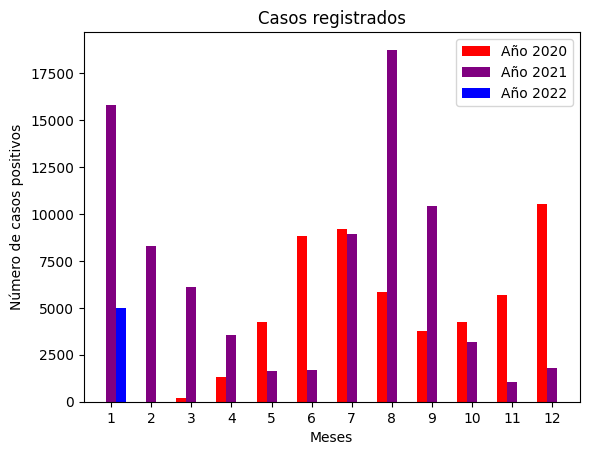

In [93]:
#Graficar los datos
plt.title("Casos registrados")

plt.xticks(Año2021['FECHA_SINTOMAS'])
width = 0.25

plt.bar(Año2020['FECHA_SINTOMAS']-width,Año2020['positivo'],color="red", width=width, label="Año 2020")
plt.legend(loc="upper left")
plt.bar(Año2021['FECHA_SINTOMAS'],Año2021['positivo'],color="purple", width=width, label="Año 2021")
plt.legend(loc="upper left")
plt.bar(Año2022['FECHA_SINTOMAS']+width,Año2022['positivo'],color="blue", width=width, label="Año 2022")
plt.legend(loc="upper right")

plt.xlabel("Meses") 
plt.ylabel("Número de casos positivos") 

#2. Ajustar la primera ola con mínimos cuadrados.

In [94]:
print(Año2020['FECHA_SINTOMAS'].dtypes)
print(Año2020['positivo'].dtypes)

int64
int64


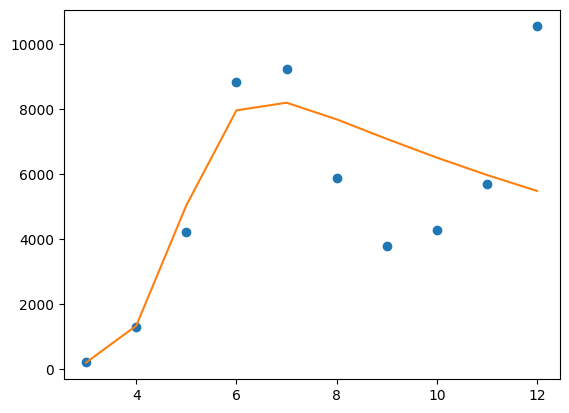

In [95]:
from scipy import integrate, optimize

##seleccionar los datos que sean del año 2020
tiempo=Año2020['FECHA_SINTOMAS']
positivos=Año2020['positivo']

#convertir los datos a tipo flotante
tiempo = np.array(tiempo, dtype=float)
positivos = np.array(positivos, dtype=float)

#Modelor SIR
def SIR(y, t, beta, gamma):
    S = y[0]
    I = y[1]
    R = y[2]
    N=S+I+R

    dS = -beta * S*I/N
    dI = beta * S*I/N - gamma*I
    dR = gamma*I
    return dS, dI, dR

def fit_odeint(t, gamma, beta):
    return integrate.odeint(SIR, (S0, I0, R0), t, args=(beta, gamma))[:,1]

#Resolver el modelo
N = 10000.0
I0 = positivos[0]
S0 = N - I0
R0 = 0.0

popt, pcov = optimize.curve_fit(fit_odeint, tiempo, positivos)
fitted = fit_odeint(tiempo, *popt)

#Gráfica
plt.plot(tiempo, positivos, 'o')
plt.plot(tiempo, fitted)
plt.show()



#3.Ajustar la segunda ola con una cadena de Monte Carlo y dar intervalos de confianza para los parámetros.

In [96]:
tiempo=Año2021['FECHA_SINTOMAS']
positivos=Año2021['positivo']

#Parámetros de la simulación Monte Carlo
sigma_gamma = 0.01 #tamaño de paso
sigma_beta = 0.01 #tamaño de paso
gamma = 0.333  # coordenada del punto donde inicia el camiante aleatorio 
beta = 0.499 # coordenada del punto donde inicia el camiante aleatorio 

like=0.00001
loglike=np.log(like)
Number_of_steeps = 100000
Burn_in_Time = 10000 #tomamos 1000 pasos de los 10000
mcmc_file_name = "mcmc.dat" # se genera el archivo mcmc.dat

In [97]:
#mcmc_utils

def PoissonLikelihood(dat, model_prediction):
	loglike=0.0
	for x, L in zip(dat, model_prediction): # dat va a sustiruir a x # model_prediction la va a sustituir en L
		if(L>0.0):
			loglike = loglike - L + x*np.log(L) # -\sum(\lamda_i) +  \sum(x_iLn\lamda_i)
	return loglike

#Modelo SIR		
def SIR(y,t,gamma,beta):
	S=y[0]
	I=y[1]
	R=y[2]
	N=S+I+R
	
	dS = -beta * S*I/N
	dI = beta * S*I/N - gamma*I
	dR = gamma*I
	return np.array([dS,dI,dR])

In [98]:
from scipy.integrate import odeint

file_h = open(mcmc_file_name,"w+",buffering=1)
file_h.write('gamma,beta,log_likelihood\n')
random=0

for i in range(Number_of_steeps):
	#verificar que sea positivo
	gamma_try = np.random.normal(gamma, sigma_gamma) #centrado en gamma, ancho
	while (gamma_try < 0.0): #verificar que gamma es positivo
		gamma_try = np.random.normal(gamma, sigma_gamma)
	beta_try = np.random.normal(beta, sigma_beta)
	while (beta_try < 0.0):  #verificar que beta es positivo
		beta_try = np.random.normal(beta, sigma_beta)
		
	#definir el modelo con los parametros elegidos
	def model(y,t):
		return SIR(y,t,gamma_try,beta_try)
		
	#resolver el modelo
	N0=100000.0
	y0 = np.array([N0-1.,1.,0.])
	model_prediction = odeint(model, y0, tiempo) #usamos libreria odeint para encntrar la solución #days dias donde tengods 
	
	#calcular likelihood
	loglike_try = PoissonLikelihood(positivos,model_prediction[:,1]) #datos de las infectados
	
	#calcular numero aleatorio para comparar con la division de la anterior
	if (loglike_try < loglike):
		random = np.random.uniform(0.0,1.0)
		accepted = np.exp(loglike_try - loglike)
	else:
		accepted = 1.
		
	if ( random < accepted):
		gamma = gamma_try
		beta = beta_try
		loglike = loglike_try

	if(i>Burn_in_Time):
		line = '{} , {} , {} \n'.format(gamma,beta,loglike)
		file_h.write(line)


file_h.close()

In [99]:
#Leer la Cadena Monte Carlo generada y elegir los parámetros del modelo con mayor verosimilitud
MCMC = pd.read_csv(mcmc_file_name)
MCMC.head()

,gamma,beta,log_likelihood
0,1.524596,3.281843,435363.081765
1,1.524596,3.281843,435363.081765
2,1.524596,3.281843,435363.081765
3,1.524596,3.281843,435363.081765
4,1.524596,3.281843,435363.081765


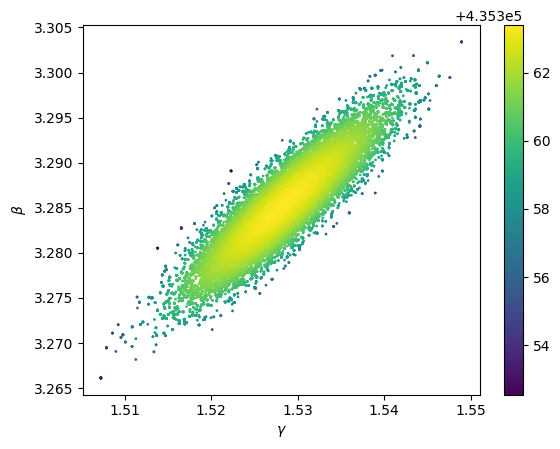

In [100]:
#Gráfica
plt.scatter(x=MCMC.gamma,y=MCMC.beta,c=MCMC.log_likelihood,s=1)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()
plt.show()

In [101]:
#Quitar parámetros repeditos y me quedo con el máximo
df = MCMC.drop_duplicates()
print(df.shape)
max_like = df['log_likelihood'].max() 

best_parameters = df[df['log_likelihood']==max_like]
gamma_best = best_parameters['gamma'].values[0]
beta_best = best_parameters['beta'].values[0]
print(gamma_best)
print(beta_best)
MCMC.quantile([0.05,0.95]) #IC del 90% porque de un lado le quito el 5% y del otro también le quito el 5%(100%-95%)

(11490, 3)
1.5282982483108636
3.285244621388512


,gamma,beta,log_likelihood
0.05,1.520391,3.278121,435360.402417
0.95,1.536561,3.292729,435363.350068


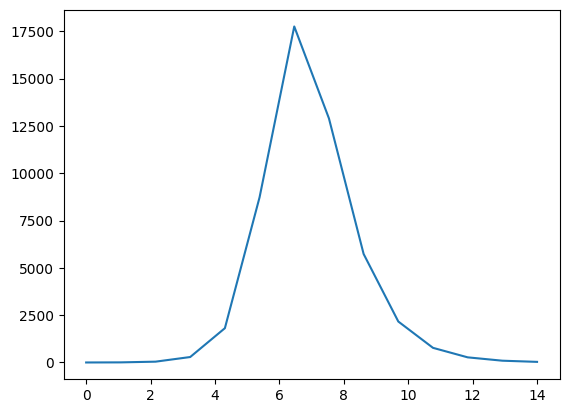

In [102]:
#Correr el modelo con los parámetros encontrados
N0=100000.0
y0 = np.array([N0-1.,1.,0.])
def model(y,t):
		return SIR(y,t,gamma_best,beta_best)
  
time = np.linspace(0.0,14.0,14)
y = odeint(model,y0,time)
Model_Infected= y[:,1]
plt.plot(time,Model_Infected)